In [1]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
import datetime

In [2]:
f = pyedflib.EdfReader(r"D:\BaiduNetdiskDownload\sz1.edf")
n = f.signals_in_file
signal_labels = f.getSignalLabels()
record = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    record[i, :] = f.readSignal(i)

In [191]:
def Q_P(x,y,bins):
    '''
    x,y 代表两个信号
    bins代表区间
    该函数返回每个区间的Q、P值
    '''
    sxy=pd.DataFrame({'x':x,'y':y})
    #sxy=sxy.sort_values(by='x')
    #sxy.index=range(len(sxy))
    sxy['bins']=pd.cut(sxy['x'],bins,labels=range(1,len(bins)),include_lowest=True)
    Q=[]
    P=[]
    for i in range(len(bins)-1):
        Q.append(sxy[sxy.bins==i+1]['y'].mean())
        P.append((bins[i]+bins[i+1])/2) 
    return Q,P

def sx(i,x,P):
    '''
    i的取值范围是[1,len(P)-1]
    '''
    lp=len(P)
    if(i==1):
        if x<=P[1]:
            return 1
        else:
            return 0
    if(i==lp-1):
        if x>P[lp-2]:
            return 1
        else:
            return 0
    if P[i-1]<x<=P[i]:
        return 1
    else:
        return 0
    
def gx(i,x,Q,P):
    '''
    i的取值范围是[1,len(P)-1]
    '''
    k=(Q[i]-Q[i-1])/(P[i]-P[i-1])
    gx=k*(x-P[i-1])+Q[i-1]
    return gx

def fx(x,Q,P):
    '''
    L: the number of bins
    '''
    L=len(P)
    fx=0
    for i in range(L-1):
        fx+=sx(i+1,x,P)*gx(i+1,x,Q,P)
    return fx   

def h2(y,f):
    my=np.mean(y)
    sst=np.sum((y-my)**2)
    sse=np.sum((y-f)**2)
    h2=1-sse/sst
    return h2

In [185]:
def H2(s1,s2,L=7):
    bins1=np.linspace(np.min(s1),np.max(s1),L)
    Q1,P1=Q_P(s1,s2,bins1)
    f1=[]
    
    for x in s1:
        f1.append(fx(x,Q1,P1))
    f1=np.array(f1)
    h2s1=h2(s2,f1)
    
    bins2=np.linspace(np.min(s2),np.max(s2),L)
    Q2,P2=Q_P(s2,s1,bins2)
    f2=[]
    for x in s2:
        f2.append(fx(x,Q2,P2))
    f2=np.array(f2)
    h2s2=h2(s1,f2)
    
    s_h2 = [h2s1,h2s2]
    #H2=np.array([[0,h2s1],[h2s2,0]])
    #PQ=[[P1,Q1],[P2,Q2]]
    #return H2,PQ
    return s_h2


def H2_xy(sx,sy,L=7):
    bins = np.linspace(np.min(sx),np.max(sx),L)
    Q,P =Q_P(sx,sy,bins)
    f=[]
    for x in sx:
        f.append(fx(x,Q,P))
    f=np.array(f)
    h2_xy=h2(sy,f)
    #PQ=[P,Q]
    #return h2_xy,PQ
    return h2_xy

In [56]:
def H2_whole(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    signals：原始信号，numpy矩阵类型（二维矩阵），不求平均，穷举
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    
    h2_value = []
    lag_value = []
    
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = start_time_window*sampleFreq
        stop_samples = stop_time_window*sampleFreq
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            for si2 in range(si1+1,signals_num):
                 # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                # 考虑时间延迟
                # 计算x到y
                sample_maxlag = int(maxlag*sampleFreq)
                for tagi in range(sample_maxlag): # x向右移动，符号为正；y向右移动，符号为负
                    #print(start_samples,stop_samples)
                    s1 = signals[si1][start_samples:stop_samples]
                    s1m = signals[si1][start_samples+tagi:stop_samples+tagi]
                    s2 = signals[si2][start_samples:stop_samples]
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi]
                    # setSignaltoZero([s1,s1m,s2,s2m],1)  # 做归0处理
                    
                    h2_mn = H2(s1m,s2,L) # s1向右移
                    h2_nm = H2(s1,s2m,L) # s2向右移
                    
                    if (h2_mn[0]>two_signals_h2[0])&(h2_mn[0]>h2_nm[0]):
                        two_signals_h2[0] = h2_mn[0]
                        two_signals_lag[0] = tagi
                        
                    elif h2_nm[0]>two_signals_h2[0]:
                        two_signals_h2[0] = h2_nm[0]
                        two_signals_lag[0] = -tagi
                        
                    if (h2_mn[1]>two_signals_h2[1])&(h2_mn[1]>h2_nm[0]):
                        two_signals_h2[1] = h2_mn[1]
                        two_signals_lag[1] = -tagi
                        
                    elif h2_nm[1]>two_signals_h2[1]:
                        two_signals_h2[1] = h2_nm[1]
                        two_signals_lag[1] = tagi
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    return h2_value,lag_value

In [47]:
def H2_whole2(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    版本2：求平均，穷举
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    
    h2_value = []
    lag_value = []
    
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = start_time_window*sampleFreq
        stop_samples = stop_time_window*sampleFreq
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            # s1 = signals[si1][start_samples:stop_samples]
            [s1] = setSignaltoZero([signals[si1][start_samples:stop_samples]]) # 做归0处理
            for si2 in range(si1+1,signals_num):
                # s2 = signals[si2][start_samples:stop_samples]
                [s2] = setSignaltoZero([signals[si2][start_samples:stop_samples]])
                 # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                
                h2_00 = H2(s1,s2,L)
                two_signals_h2[0] = h2_00[0]
                two_signals_h2[1] = h2_00[1]
                # 考虑时间延迟
                # 计算x到y
                sample_maxlag = int(maxlag*sampleFreq)
                for tagi in range(1,sample_maxlag): # x向右移动，符号为正；y向右移动，符号为负
                    #print(start_samples,stop_samples)
                    s1m = signals[si1][start_samples+tagi:stop_samples+tagi]
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi]
                    [s1m,s2m] = setSignaltoZero([s1m,s2m],1)  # 做归0处理
                    
                    h2_mn = H2(s1m,s2,L) # s1向右移
                    h2_nm = H2(s1,s2m,L) # s2向右移
                    
                    if (h2_mn[0]>two_signals_h2[0])&(h2_mn[0]>h2_nm[0]):
                        two_signals_h2[0] = h2_mn[0]
                        two_signals_lag[0] = tagi
                        
                    elif h2_nm[0]>two_signals_h2[0]:
                        two_signals_h2[0] = h2_nm[0]
                        two_signals_lag[0] = -tagi
                        
                    if (h2_mn[1]>two_signals_h2[1])&(h2_mn[1]>h2_nm[0]):
                        two_signals_h2[1] = h2_mn[1]
                        two_signals_lag[1] = -tagi
                        
                    elif h2_nm[1]>two_signals_h2[1]:
                        two_signals_h2[1] = h2_nm[1]
                        two_signals_lag[1] = tagi
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    return h2_value,lag_value


In [128]:
def H2_whole3(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    版本3：不求平均，穷举
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    time_flexity=1
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    
    h2_value = []
    lag_value = []
    
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = int(start_time_window*sampleFreq)
        stop_samples = int(stop_time_window*sampleFreq)
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            s1 = signals[si1][start_samples:stop_samples]
            # [s1] = setSignaltoZero([signals[si1][start_samples:stop_samples]]) # 做归0处理
            for si2 in range(si1+1,signals_num):
                s2 = signals[si2][start_samples:stop_samples]
                #[s2] = setSignaltoZero([signals[si2][start_samples:stop_samples]])
                # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                
                h2_00 = H2(s1,s2,L)
                two_signals_h2[0] = h2_00[0]
                two_signals_h2[1] = h2_00[1]
                # 考虑时间延迟
                # 计算x到y
                sample_maxlag = int(maxlag*sampleFreq)
                for tagi in range(1,sample_maxlag): # x向右移动，符号为正；y向右移动，符号为负
                    #print(start_samples,stop_samples)
                    time_flexity += 1
                    s1m = signals[si1][start_samples+tagi:stop_samples+tagi]
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi]
                    #[s1m,s2m] = setSignaltoZero([s1m,s2m],1)  # 做归0处理
                    
                    h2_mn = H2(s1m,s2,L) # s1向右移
                    h2_nm = H2(s1,s2m,L) # s2向右移
                    
                    if (h2_mn[0]>two_signals_h2[0])&(h2_mn[0]>h2_nm[0]):
                        two_signals_h2[0] = h2_mn[0]
                        two_signals_lag[0] = tagi
                        
                    elif h2_nm[0]>two_signals_h2[0]:
                        two_signals_h2[0] = h2_nm[0]
                        two_signals_lag[0] = -tagi
                        
                    if (h2_mn[1]>two_signals_h2[1])&(h2_mn[1]>h2_nm[0]):
                        two_signals_h2[1] = h2_mn[1]
                        two_signals_lag[1] = -tagi
                        
                    elif h2_nm[1]>two_signals_h2[1]:
                        two_signals_h2[1] = h2_nm[1]
                        two_signals_lag[1] = tagi
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    print(time_flexity)
    return h2_value,lag_value

In [108]:
def H2_whole_modify(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    版本4：不求平均,lag算法改进
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    time_flexity=0
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    if maxlag <= 0:
        print("Time maxlag must be greater than zero!")
        
    h2_value = []
    lag_value = []
    
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = int(start_time_window*sampleFreq)
        stop_samples = int(stop_time_window*sampleFreq)
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            s1 = signals[si1][start_samples:stop_samples]
            # [s1] = setSignaltoZero([signals[si1][start_samples:stop_samples]]) # 做归0处理
            
            for si2 in range(si1+1,signals_num):
                s2 = signals[si2][start_samples:stop_samples]
                #[s2] = setSignaltoZero([signals[si2][start_samples:stop_samples]])
                
                # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                
                h2_00 = H2(s1,s2,L)
                time_flexity += 1
                two_signals_h2[0] = h2_00[0]
                two_signals_h2[1] = h2_00[1]
                # 考虑时间延迟
                # 计算x到y
                
                maxlag_points = int(maxlag*sampleFreq) # 总共样本点
                lag_interval = [0,maxlag_points] # time lag区间
                intervalDELta = lag_interval[1]-lag_interval[0]
                # 不盲目计算所有移动点的h2，采样计算
                if intervalDELta > 12:
                    
                    sample_num = round(intervalDELta**0.5)
                    #sample_point
                    sample_points = np.percentile(range(lag_interval[0],lag_interval[1]),np.linspace(0,100,sample_num),interpolation='nearest')
                    two_signals_sample_h2 = [[],[]] 
                    for tagi in sample_points[1:]: # x向右移动，符号为正；y向右移动，符号为负
                        time_flexity += 2
                        s1m = signals[si1][start_samples+tagi:stop_samples+tagi]
                        s2m = signals[si2][start_samples+tagi:stop_samples+tagi]
                        
                        h2_mn = H2(s1m,s2,L) # s1向右移
                        h2_nm = H2(s1,s2m,L) # s2向右移
                        
                        two_signals_sample_h2[0].append(h2_mn[0])
                        two_signals_sample_h2[0].append(h2_nm[0])
                        two_signals_sample_h2[1].append(h2_mn[1])
                        two_signals_sample_h2[1].append(h2_nm[1])
                    
                    t1_h2 = np.max(two_signals_sample_h2[0])
                    t2_h2 = np.max(two_signals_sample_h2[1])
                    
                    if t1_h2>two_signals_h2[0]:
                        two_signals_h2[0] = t1_h2
                        sub1_h2 = np.where(two_signals_sample_h2[0]==t1_h2)[0][0]
                        if(sub1_h2%2==0): #说明s1向右移了
                            two_signals_lag[0] = sample_points[sub1_h2//2+1]
                        else:  #说明s2向右移了
                            two_signals_lag[0] = -sample_points[sub1_h2//2+1]
                        #if sub1_h2
                    
                    if t2_h2>two_signals_h2[1]:
                        two_signals_h2[1] = t2_h2
                        sub2_h2 = np.where(two_signals_sample_h2[1]==t2_h2)[0][0]
                        if(sub2_h2%2==0): #说明s1向右移了
                            two_signals_lag[1] = -sample_points[sub2_h2//2+1]
                        else:  #说明s2向右移了
                            two_signals_lag[1] = sample_points[sub2_h2//2+1]
                    
                    
                    #while 
                    '''
                    if (h2_mn[0]>two_signals_h2[0])&(h2_mn[0]>h2_nm[0]):
                        two_signals_h2[0] = h2_mn[0]
                        two_signals_lag[0] = tagi
                        
                    elif h2_nm[0]>two_signals_h2[0]:
                        two_signals_h2[0] = h2_nm[0]
                        two_signals_lag[0] = -tagi
                        
                    if (h2_mn[1]>two_signals_h2[1])&(h2_mn[1]>h2_nm[0]):
                        two_signals_h2[1] = h2_mn[1]
                        two_signals_lag[1] = -tagi
                        
                    elif h2_nm[1]>two_signals_h2[1]:
                        two_signals_h2[1] = h2_nm[1]
                        two_signals_lag[1] = tagi
                    '''
                    
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    print(time_flexity)
    return h2_value,lag_value

In [145]:
def compare3(one,two,three):
    """
    比较3个数的大小，返回最大值及其索引（位置）
    """
    if one >= max(two,three):
        return one,1
    if two >= three:
        return two,2
    return three,3

    
def H2_whole_dichotomy(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    版本5：不求平均,lag算法改进,采用二分法计算最大h2
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    if maxlag <= 0:
        print("Time maxlag must be greater than zero!")
        
    h2_value = []
    lag_value = []
    dict_sample = dict()
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = int(start_time_window*sampleFreq)
        stop_samples = int(stop_time_window*sampleFreq)
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            s1 = signals[si1][start_samples:stop_samples]
            # [s1] = setSignaltoZero([signals[si1][start_samples:stop_samples]]) # 做归0处理
            
            for si2 in range(si1+1,signals_num):
                s2 = signals[si2][start_samples:stop_samples]
                #[s2] = setSignaltoZero([signals[si2][start_samples:stop_samples]])
                
                # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                
                h2_00 = H2(s1,s2,L)
                
                two_signals_h2[0] = h2_00[0]
                two_signals_h2[1] = h2_00[1]
                # 考虑时间延迟
                # 计算x到y
                
                maxlag_points = int(maxlag*sampleFreq) # 总共样本点
                left = new_left = new_median = new_right = 0
                median = maxlag_points//2
                right = maxlag_points - 1
                
                # sample_points = [left,median,right]
                    
#                 left0_h2 = two_signals_h2[0]
#                 left1_h2 = two_signals_h2[1]
                median0_h2 = median1_h2 = right0_h2 = right1_h2 = 0
                
                # x向右移动，符号为正；y向右移动，符号为负
                
                median_s1m = signals[si1][start_samples+median:stop_samples+median]
                median_s2m = signals[si2][start_samples+median:stop_samples+median]
                
                right_s1m = signals[si1][start_samples+right:stop_samples+right]
                right_s2m = signals[si2][start_samples+right:stop_samples+right]
                
                median_h2_mn = H2(median_s1m,s2,L) # s1向右移
                median_h2_nm = H2(s1,median_s2m,L) # s2向右移
                
                right_h2_mn = H2(right_s1m,s2,L) # s1向右移
                right_h2_nm = H2(s1,right_s2m,L) # s2向右移
                
                t0_h2 = [two_signals_h2[0],median_h2_nm[0],median_h2_mn[0],right_h2_nm[0],right_h2_mn[0]]
                t1_h2 = [two_signals_h2[1],median_h2_mn[1],median_h2_nm[1],right_h2_mn[1],right_h2_nm[1]]
                
                t0_h2_max = max(t0_h2)
                t1_h2_max = max(t1_h2)
                
                t0_index = t0_h2.index(t0_h2_max)
                t1_index = t1_h2.index(t1_h2_max)
                
                old_h2_value = [0,0,0]
                dict_sample.clear()
                
                sign = 1 # 符号位，判断是x移动还是y移动
                
                if t0_index: # 如果 t0_index>0,说明0除不是最大值
                    two_signals_h2[0] = t0_h2_max
                    sign = (-1)**t0_index
                    if t0_index <= 2:
                        two_signals_lag[0] = sign*median
                        new_left = (median+left)//2
                        new_median = median
                        new_right = (median+right)//2
                        #old_h2_value[1] = t0_h2_max
                    else:
                        two_signals_lag[0] = sign*right
                        new_left = median
                        new_median = (median+right)//2
                        new_right = right
                        #old_h2_value[0] = t0_h2[t0_index-2]
                        #old_h2_value[2] = t0_h2_max
                else:
                    if t0_h2[1] > t0_h2[2]: # 如果中值情况下，s2向右移的h2大于s1向右移，则符号为负
                        sign = -1
#                         old_h2_value[2]=t0_h2[1]
#                     else:
#                         old_h2_value[2]=t0_h2[2]
                    new_left = left
                    new_median = (median+left)//2
                    new_right = median
                    #old_h2_value[0] = t0_h2_max
                print(sign)    
                dict_sample[left]=t0_h2[0]
                if sign>0:
                    dict_sample[median]=t0_h2[2]
                    dict_sample[right]=t0_h2[4]
                else:
                    dict_sample[median]=t0_h2[1]
                    dict_sample[right]=t0_h2[3]
                    
                while (new_right-new_left) > 2:
                    t0_h2 = []
                    if dict_sample.get(new_left):
                        t0_h2.append(dict_sample[new_left])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_left:stop_samples+new_left]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_left:stop_samples+new_left]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_left] = t0_h2[0]
                            
                    if dict_sample.get(new_median):
                        t0_h2.append(dict_sample[new_median])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_median:stop_samples+new_median]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_median:stop_samples+new_median]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_median] = t0_h2[1]
                        
                    if dict_sample.get(new_right):
                        t0_h2.append(dict_sample[new_right])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_right:stop_samples+new_right]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_right:stop_samples+new_right]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_right] = t0_h2[2]
                            
                    two_signals_h2[0] = max(t0_h2)
                    t0_index = t0_h2.index(two_signals_h2[0])
                    
                    if t0_index == 1:
                        two_signals_lag[0] = sign*new_median
                        left = new_left
                        right = new_right
                        new_left = (new_left+new_median)//2
                        new_right = (new_median+new_right)//2
                    elif t0_index == 0:
                        two_signals_lag[0] = sign*new_left
                        if left==new_left:
                            right = new_right = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            right = new_median
                            new_right = (new_median+new_left)//2
                            new_median = new_left
                            new_left = (left+new_left)//2
                    else:
                        two_signals_lag[0] = sign*new_right
                        if right==new_right:
                            left = new_left = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            left = new_median
                            new_left = (new_median+new_right)//2
                            new_median = new_right
                            new_right = (new_right+right)//2
                            
                    print(t0_index,left,right,new_left,new_median,new_right)        
                print(dict_sample)
                
#                 if t1_index: # 如果 t0_index>0,说明0除不是最大值
#                     two_signals_h2[1] = t1_h2_max
#                     if t1_index <= 2:
#                         two_signals_lag[1] = ((-1)**t1_index)*median
#                         new_left = (median+left)//2
#                         new_median = median
#                         new_right = (median+right)//2
                        
                        
                        
#                     else:
#                         two_signals_lag[1] = ((-1)**t1_index)*right
#                         new_left = median
#                         new_median = (median+right)//2
#                         new_right = right
                        
#                 else:
#                     new_left = left
#                     new_median = (median+left)//2
#                     new_right = median
                
                
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    #print(time_flexity)
    return h2_value,lag_value

In [173]:
def H2_whole_dichotomy2(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    版本6：不求平均,lag算法改进,采用二分法计算最大h2，初始采用7点采样（而不是三点）
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    if maxlag <= 0:
        print("Time maxlag must be greater than zero!")
        
    h2_value = []
    lag_value = []
    dict_sample = dict()
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = int(start_time_window*sampleFreq)
        stop_samples = int(stop_time_window*sampleFreq)
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            s1 = signals[si1][start_samples:stop_samples]
            # [s1] = setSignaltoZero([signals[si1][start_samples:stop_samples]]) # 做归0处理
            
            for si2 in range(si1+1,signals_num):
                s2 = signals[si2][start_samples:stop_samples]
                #[s2] = setSignaltoZero([signals[si2][start_samples:stop_samples]])
                
                # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                
                h2_00 = H2(s1,s2,L)
                
                two_signals_h2[0] = h2_00[0]
                two_signals_h2[1] = h2_00[1]
                # 考虑时间延迟
                # 计算x到y
                
                maxlag_points = int(maxlag*sampleFreq) # 总共样本点
                sample_num = int(maxlag_points**0.5-maxlag_points**0.25)
                if sample_num < 3:
                    sample_num = 3
                sample_points = np.percentile(range(0,maxlag_points),np.linspace(0,100,sample_num),interpolation='nearest')
                
                t0_h2 = []
                t1_h2 = []
                dict_sample.clear()
                sign = 1 # 符号位，判断是x移动还是y移动
                left = right = new_left = new_median = new_right = 0
                
                for tagi in sample_points[1:]: # x向右移动，符号为正；y向右移动，符号为负
                    
                    s1m = signals[si1][start_samples+tagi:stop_samples+tagi]
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi]

                    h2_mn = H2(s1m,s2,L) # s1向右移
                    h2_nm = H2(s1,s2m,L) # s2向右移

                    t0_h2.extend([h2_mn[0],h2_nm[0]])
                    t1_h2.extend([h2_mn[1],h2_nm[1]])
                
                t0_h2_max = max(t0_h2)
                t1_h2_max = max(t1_h2)
                
                t0_index = t0_h2.index(t0_h2_max)
                t1_index = t1_h2.index(t1_h2_max)
                
                sign = (-1)**t0_index
                if t0_h2_max>two_signals_h2[0]:
                    two_signals_h2[0] = t0_h2_max
                    sub0_h2 = t0_index//2 + 1
                    two_signals_lag[0] = sign*sample_points[sub0_h2]
                    if sub0_h2 < (sample_num - 1):
                        left = sample_points[sub0_h2-1]
                        right = sample_points[sub0_h2+1]
                        new_median = sample_points[sub0_h2]
                        new_left = (left+new_median)//2
                        new_right = (right+new_median)//2
                        #dict_sample[left] = t0_h2[t0_index-2]
                        dict_sample[new_median] = t0_h2[t0_index]
                        #dict_sample[right] = t0_h2[t0_index+2]
                    else:
                        left = sample_points[sub0_h2-2]
                        new_right = right = sample_points[sub0_h2]
                        new_median = (sample_points[sub0_h2]+sample_points[sub0_h2-1])//2
                        new_left = (sample_points[sub0_h2-1]+sample_points[sub0_h2-2])//2
                        dict_sample[sample_points[sub0_h2-1]] = t0_h2[t0_index-2]
                        dict_sample[right] = t0_h2[t0_index]
                else:
                    right = sample_points[2]
                    new_left = left = 0
                    new_right = (right+sample_points[1])//2
                    new_median = sample_points[1]//2
                    dict_sample[sample_points[1]] = t0_h2[(1-sign)//2]
                    dict_sample[0] = two_signals_h2[0]
                
                #print(sign,t0_index,sample_points[t0_index//2 + 1],left,right,new_left,new_median,new_right)
                while (new_right-new_left) >= 2:
                    t0_h2 = []
                    if dict_sample.get(new_left):
                        t0_h2.append(dict_sample[new_left])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_left:stop_samples+new_left]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_left:stop_samples+new_left]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_left] = t0_h2[0]
                            
                    if dict_sample.get(new_median):
                        t0_h2.append(dict_sample[new_median])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_median:stop_samples+new_median]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_median:stop_samples+new_median]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_median] = t0_h2[1]
                        
                    if dict_sample.get(new_right):
                        t0_h2.append(dict_sample[new_right])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_right:stop_samples+new_right]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_right:stop_samples+new_right]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_right] = t0_h2[2]
                            
                    two_signals_h2[0] = max(t0_h2)
                    t0_index = t0_h2.index(two_signals_h2[0])
                    
                    if t0_index == 1:
                        two_signals_lag[0] = sign*new_median
                        left = new_left
                        right = new_right
                        new_left = (new_left+new_median)//2
                        new_right = (new_median+new_right)//2
                    elif t0_index == 0:
                        two_signals_lag[0] = sign*new_left
                        if left==new_left:
                            right = new_right = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            right = new_median
                            new_right = (new_median+new_left)//2
                            new_median = new_left
                            new_left = (left+new_left)//2
                    else:
                        two_signals_lag[0] = sign*new_right
                        if right==new_right:
                            left = new_left = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            left = new_median
                            new_left = (new_median+new_right)//2
                            new_median = new_right
                            new_right = (new_right+right)//2
                    
                sign = (-1)**(t1_index+1)
                dict_sample.clear()
                if t1_h2_max>two_signals_h2[1]:
                    two_signals_h2[1] = t1_h2_max
                    sub1_h2 = t1_index//2 + 1
                    two_signals_lag[1] = sign*sample_points[sub1_h2]
                    if sub1_h2 < (sample_num - 1):
                        left = sample_points[sub1_h2-1]
                        right = sample_points[sub1_h2+1]
                        new_median = sample_points[sub1_h2]
                        new_left = (left+new_median)//2
                        new_right = (right+new_median)//2
                        #dict_sample[left] = t0_h2[t0_index-2]
                        dict_sample[new_median] = t1_h2[t1_index]
                        #dict_sample[right] = t0_h2[t0_index+2]
                    else:
                        left = sample_points[sub1_h2-2]
                        new_right = right = sample_points[sub1_h2]
                        new_median = (sample_points[sub1_h2]+sample_points[sub1_h2-1])//2
                        new_left = (sample_points[sub1_h2-1]+sample_points[sub1_h2-2])//2
                        dict_sample[sample_points[sub1_h2-1]] = t1_h2[t1_index-2]
                        dict_sample[right] = t1_h2[t1_index]
                else:
                    right = sample_points[2]
                    new_left = left = 0
                    new_right = (right+sample_points[1])//2
                    new_median = sample_points[1]//2
                    dict_sample[sample_points[1]] = t1_h2[(1+sign)//2]
                    dict_sample[0] = two_signals_h2[1]
                
                #print(sign,t0_index,sample_points[t0_index//2 + 1],left,right,new_left,new_median,new_right)
                while (new_right-new_left) >= 2:
                    t1_h2 = []
                    if dict_sample.get(new_left):
                        t1_h2.append(dict_sample[new_left])
                    else:
                        if sign<0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_left:stop_samples+new_left]
                            t1_h2.append(H2_xy(s2,sxx,L))
                        else:
                            syy = signals[si2][start_samples+new_left:stop_samples+new_left]
                            t1_h2.append(H2_xy(syy,s1,L))
                        dict_sample[new_left] = t1_h2[0]
                            
                    if dict_sample.get(new_median):
                        t1_h2.append(dict_sample[new_median])
                    else:
                        if sign<0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_median:stop_samples+new_median]
                            t1_h2.append(H2_xy(s2,sxx,L))
                        else:
                            syy = signals[si2][start_samples+new_median:stop_samples+new_median]
                            t1_h2.append(H2_xy(syy,s1,L))
                        dict_sample[new_median] = t1_h2[1]
                        
                    if dict_sample.get(new_right):
                        t1_h2.append(dict_sample[new_right])
                    else:
                        if sign<0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_right:stop_samples+new_right]
                            t1_h2.append(H2_xy(s2,sxx,L))
                        else:
                            syy = signals[si2][start_samples+new_right:stop_samples+new_right]
                            t1_h2.append(H2_xy(syy,s1,L))
                        dict_sample[new_right] = t1_h2[2]
                            
                    two_signals_h2[1] = max(t1_h2)
                    t1_index = t1_h2.index(two_signals_h2[1])
                    
                    if t1_index == 1:
                        two_signals_lag[1] = sign*new_median
                        left = new_left
                        right = new_right
                        new_left = (new_left+new_median)//2
                        new_right = (new_median+new_right)//2
                    elif t1_index == 0:
                        two_signals_lag[1] = sign*new_left
                        if left==new_left:
                            right = new_right = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            right = new_median
                            new_right = (new_median+new_left)//2
                            new_median = new_left
                            new_left = (left+new_left)//2
                    else:
                        two_signals_lag[1] = sign*new_right
                        if right==new_right:
                            left = new_left = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            left = new_median
                            new_left = (new_median+new_right)//2
                            new_median = new_right
                            new_right = (new_right+right)//2
                            
                    #print(t0_index,left,right,new_left,new_median,new_right)        
                #print(dict_sample)
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    #print(time_flexity)
    return h2_value,lag_value

In [17]:
def plot_s(s1,s1_name,s2,s2_name,tstart,tstop,L=11):
    plt.figure(figsize=(16,10))
    plt.subplot(211)
    plt.plot(s1,'r',label=s1_name)
    plt.xticks(interval(0,len(s1)-1,L),fmat(np.linspace(tstart,tstop,L)))
    plt.legend()
    plt.grid()

    plt.subplot(212)
    plt.plot(s2,'b',label=s2_name)
    plt.xticks(interval(0,len(s2)-1,L),fmat(np.linspace(tstart,tstop,L)))
    plt.grid()
    plt.legend()

    plt.show()

    
def scatter_h2(s1,s1_name,s2,s2_name,tstart,tstop,L,PQ):
    plt.figure(figsize=(15,12))
    ax1=plt.subplot(211)
    ax1.scatter(s1,s2,color='b')
    ax1.plot(PQ[0][0],PQ[0][1],'r')
    ax1.set_xlabel(s1_name)
    ax1.set_ylabel(s2_name)
    plt.xticks(interval(np.min(s1),np.max(s1),L),fmat(np.linspace(tstart,tstop,L)))
    plt.grid()

    ax2=plt.subplot(212)
    ax2.scatter(s2,s1,color='b')
    ax2.plot(PQ[1][0],PQ[1][1],'r')
    ax2.set_ylabel(s1_name)
    ax2.set_xlabel(s2_name)
    plt.xticks(interval(np.min(s2),np.max(s2),L),fmat(np.linspace(tstart,tstop,L)))
    plt.grid()

In [11]:
def setSignaltoZero(signals,iteration=1):
    '''
    signals：二维矩阵(传入引用)
    iteration:迭代次数
    '''
    n = len(signals)
    signals_mean = np.zeros(n)
    for iter in range(iteration):
        #print("Iteration: ",iter+1)
        for i in range(n):
            signals_mean[i] = np.mean(signals[i])
            signals[i] = signals[i] - signals_mean[i] #如果是数组，则返回新数组
            #print(np.mean(signals[i]))    
    return signals


interval=lambda min,max,N:np.linspace(min,max,N)
def fmat(li):
    '''
    li中的元素保留一位有效数字
    '''
    for i in range(len(li)):
        li[i]=round(li[i],1)
    return li

In [7]:
mean56_02,mean66_02=np.mean(record[56,0:2000]),np.mean(record[66,0:2000])
s56_02,s66_02=record[56,0:2000]-mean56_02,record[66,0:2000]-mean66_02

np.mean(s56_02),np.mean(s66_02)

(-1.8408172763884068e-12, -6.09361450187862e-14)

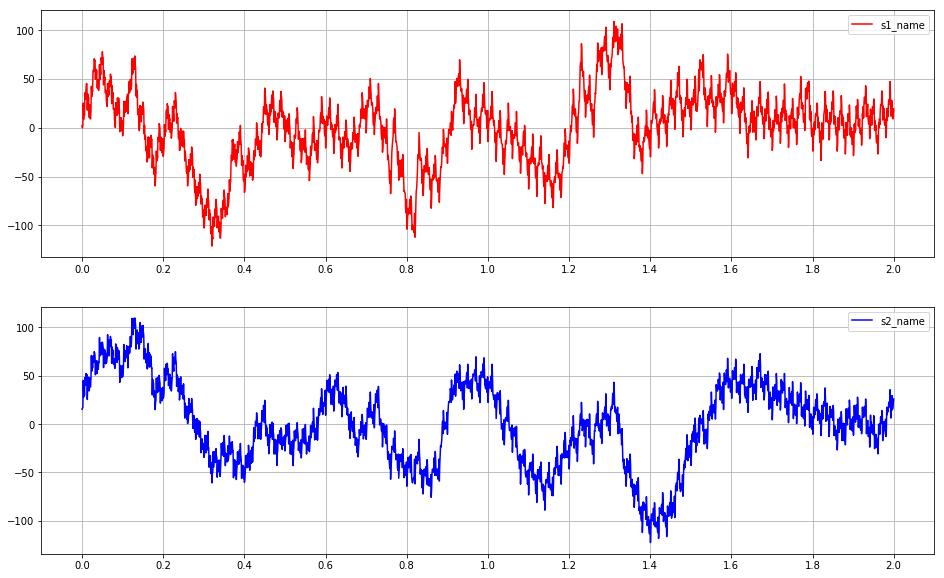

In [8]:
plot_s(s56_02,"s56_02",s66_02,"s66_02",0,2)

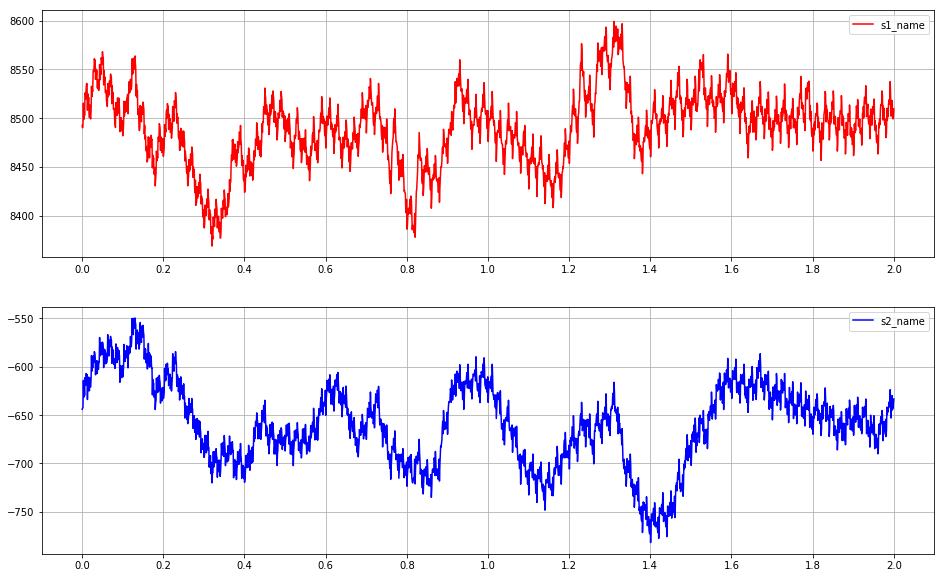

In [9]:
plot_s(record[56,0:2000],"56_02",record[66,0:2000],"66_02",0,2)

In [10]:
h2_value1= H2(s56_02,s66_02,7)
h2_value1

[0.25181297501589095, 0.30769570235771204]

In [53]:
h2_vv1 = H2(record[56,0:2000],record[66,0:2000],7)
h2_vv1

[0.25181297501589195, 0.30767201530070154]

In [55]:
np.mean(s56_02),np.mean(s66_02),np.mean(record[56,0:2000]),np.mean(record[66,0:2000])

(-1.8408172763884068e-12,
 -6.09361450187862e-14,
 8490.0924427863,
 -659.2580769207293)

In [194]:
signals1 = np.array([record[56],record[66]])
signals2 = np.array([record[46],record[56]])
signals3 = np.array([record[46],record[56],record[66]])

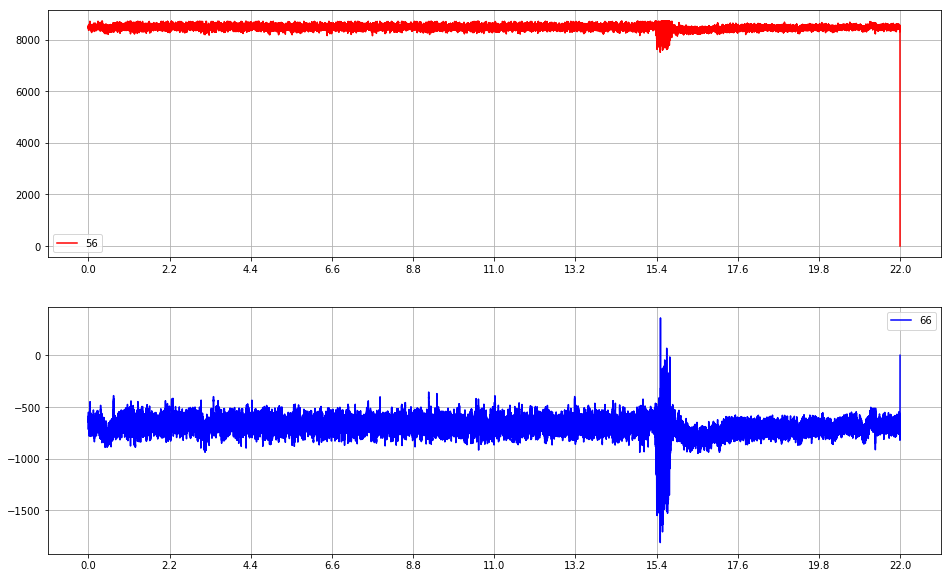

In [21]:
plot_s(signal1[0],"56",signal1[1],"66",0,f.getFileDuration()//60)

In [49]:
t_start = datetime.datetime.now()
h2_value1,lag_value1 = H2_whole(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.001)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:01.742360


In [57]:
t_start = datetime.datetime.now()
h2_value1,lag_value1 = H2_whole(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.001)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:01.742364


In [58]:
for i,h2_i in zip(range(len(h2_value1)),h2_value1):
    print(i+1,"：",h2_i)

1 ： [[0.         0.25181298]
 [0.30767202 0.        ]]
2 ： [[0.         0.27207066]
 [0.28197746 0.        ]]
3 ： [[0.        0.3942074]
 [0.417378  0.       ]]
4 ： [[0.         0.3997203 ]
 [0.40063335 0.        ]]
5 ： [[0.         0.61123895]
 [0.60553378 0.        ]]
6 ： [[0.         0.67035258]
 [0.61159242 0.        ]]
7 ： [[0.         0.30714526]
 [0.27986335 0.        ]]
8 ： [[0.         0.35236296]
 [0.37032725 0.        ]]
9 ： [[0.         0.56636265]
 [0.6724057  0.        ]]
10 ： [[0.         0.52283512]
 [0.50528227 0.        ]]


In [29]:
lag_value1

[array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]])]

In [40]:
t_start = datetime.datetime.now()
h2_value1,lag_value1 = H2_whole2(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.001)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:01.744359


In [44]:
for i,h2_i in zip(range(len(h2_value1)),h2_value1):
    print(i+1,"：",h2_i)

1 ： [[0.         0.25181298]
 [0.30767202 0.        ]]
2 ： [[0.         0.27207066]
 [0.28197746 0.        ]]
3 ： [[0.        0.3942074]
 [0.417378  0.       ]]
4 ： [[0.         0.3997203 ]
 [0.40063335 0.        ]]
5 ： [[0.         0.61123895]
 [0.60553378 0.        ]]
6 ： [[0.         0.67035258]
 [0.61159242 0.        ]]
7 ： [[0.         0.30714526]
 [0.27986335 0.        ]]
8 ： [[0.         0.35236296]
 [0.37032725 0.        ]]
9 ： [[0.         0.56636265]
 [0.6724057  0.        ]]
10 ： [[0.         0.52283512]
 [0.50528227 0.        ]]


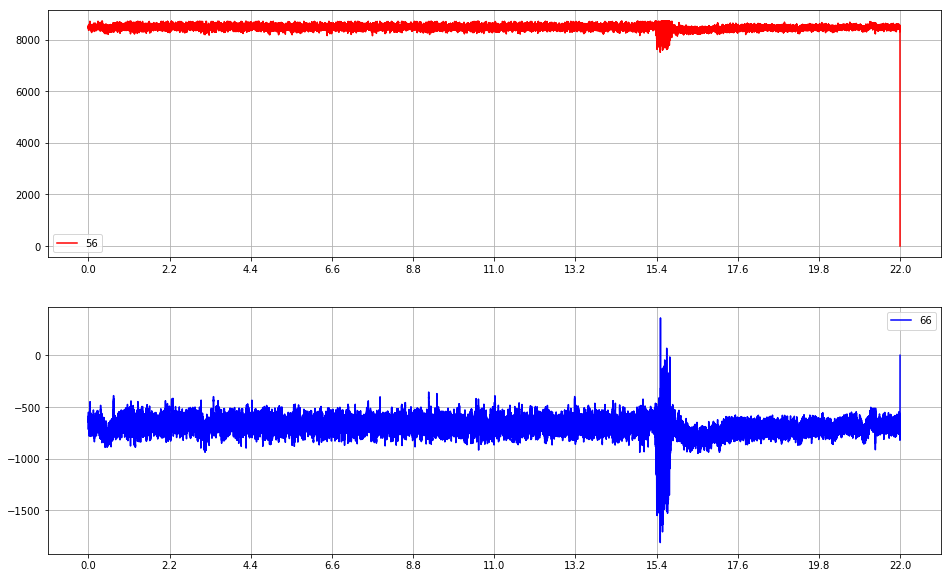

In [45]:
plot_s(signal1[0],"56",signal1[1],"66",0,f.getFileDuration()//60)

In [48]:
t_start = datetime.datetime.now()
h2_value3,lag_value3 = H2_whole2(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.001)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:00.918662


In [51]:
for i,h2_i in zip(range(len(h2_value3)),h2_value3):
    print(i+1,"：",h2_i)

1 ： [[0.         0.25181298]
 [0.3076957  0.        ]]
2 ： [[0.         0.27207066]
 [0.28197746 0.        ]]
3 ： [[0.         0.3942074 ]
 [0.41720039 0.        ]]
4 ： [[0.         0.3997203 ]
 [0.40063335 0.        ]]
5 ： [[0.         0.61123895]
 [0.60553378 0.        ]]
6 ： [[0.         0.67035258]
 [0.61175702 0.        ]]
7 ： [[0.         0.30714526]
 [0.28008357 0.        ]]
8 ： [[0.         0.35230754]
 [0.37032725 0.        ]]
9 ： [[0.         0.56636265]
 [0.6724057  0.        ]]
10 ： [[0.         0.52283512]
 [0.50528227 0.        ]]


In [60]:
t_start = datetime.datetime.now()
h2_value4,lag_value4 = H2_whole3(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.001)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:00.909666


In [61]:
for i,h2_i in zip(range(len(h2_value4)),h2_value4):
    print(i+1,"：",h2_i)

1 ： [[0.         0.25181298]
 [0.30767202 0.        ]]
2 ： [[0.         0.27207066]
 [0.28197746 0.        ]]
3 ： [[0.        0.3942074]
 [0.417378  0.       ]]
4 ： [[0.         0.3997203 ]
 [0.40063335 0.        ]]
5 ： [[0.         0.61123895]
 [0.60553378 0.        ]]
6 ： [[0.         0.67035258]
 [0.61159242 0.        ]]
7 ： [[0.         0.30714526]
 [0.27986335 0.        ]]
8 ： [[0.         0.35236296]
 [0.37032725 0.        ]]
9 ： [[0.         0.56636265]
 [0.6724057  0.        ]]
10 ： [[0.         0.52283512]
 [0.50528227 0.        ]]


In [75]:
t_start = datetime.datetime.now()
h2_value5,lag_value5 = H2_whole3(signals1,0,12,999.412,slideWindow=2,step=1,maxlag=0.001)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:00.876677


In [76]:
for i,h2_i in zip(range(len(h2_value5)),h2_value5):
    print(i+1,"：",h2_i)

1 ： [[0.         0.25165378]
 [0.30754645 0.        ]]
2 ： [[0.         0.27211493]
 [0.28226205 0.        ]]
3 ： [[0.         0.39255288]
 [0.41659807 0.        ]]
4 ： [[0.         0.39470811]
 [0.39708656 0.        ]]
5 ： [[0.         0.60733353]
 [0.60390269 0.        ]]
6 ： [[0.         0.67554096]
 [0.61471434 0.        ]]
7 ： [[0.         0.3071358 ]
 [0.27933234 0.        ]]
8 ： [[0.         0.35051107]
 [0.36859145 0.        ]]
9 ： [[0.         0.56545725]
 [0.66944437 0.        ]]
10 ： [[0.         0.52036635]
 [0.50354915 0.        ]]


In [72]:
t_start = datetime.datetime.now()
h2_value6,lag_value6 = H2_whole2(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.001,L=8)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:01.053614


In [73]:
for i,h2_i in zip(range(len(h2_value6)),h2_value6):
    print(i+1,"：",h2_i)

1 ： [[0.         0.25485268]
 [0.32832694 0.        ]]
2 ： [[0.         0.27810995]
 [0.30407084 0.        ]]
3 ： [[0.         0.39552274]
 [0.42246138 0.        ]]
4 ： [[0.         0.39999285]
 [0.40016801 0.        ]]
5 ： [[0.         0.61672601]
 [0.60813164 0.        ]]
6 ： [[0.         0.66422978]
 [0.6212087  0.        ]]
7 ： [[0.         0.31313496]
 [0.29111886 0.        ]]
8 ： [[0.         0.35159977]
 [0.38831122 0.        ]]
9 ： [[0.         0.57571264]
 [0.65886859 0.        ]]
10 ： [[0.        0.5250041]
 [0.5132571 0.       ]]


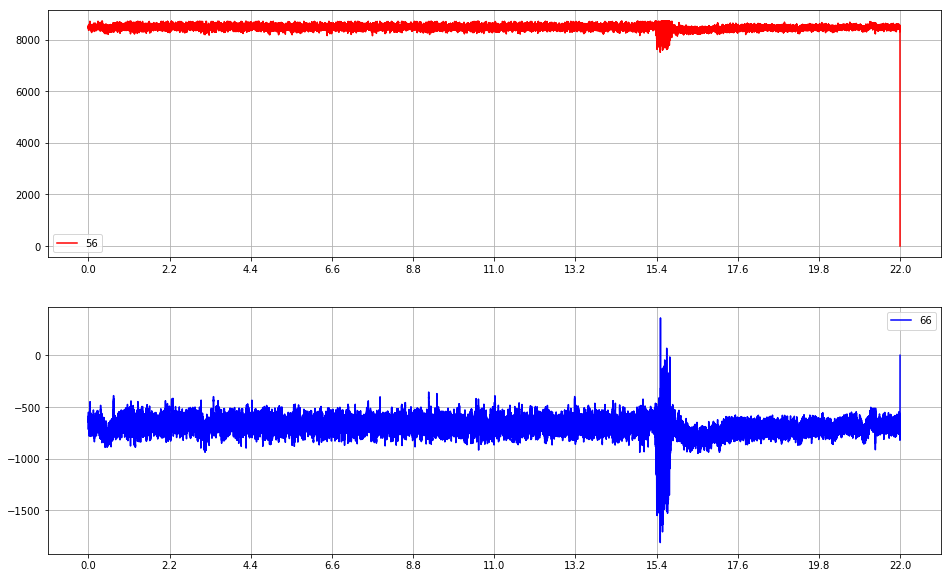

In [52]:
plot_s(signal1[0],"56",signal1[1],"66",0,f.getFileDuration()//60)

In [78]:
t_start = datetime.datetime.now()
h2_value7,lag_value7 = H2_whole3(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:03:09.731356


In [90]:
t_start = datetime.datetime.now()
h2_value7,lag_value7 = H2_whole3(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

991
0:03:00.829623


In [86]:
for i,h2_i,lag_i in zip(range(len(h2_value7)),h2_value7,lag_value7):
    print(i+1,"：",lag_i[0],lag_i[1],'\n',h2_i)
    print()

1 ： [0. 0.] [0. 0.] 
 [[0.         0.25181298]
 [0.30767202 0.        ]]

2 ： [  0. -99.] [99.  0.] 
 [[0.         0.35118581]
 [0.47353308 0.        ]]

3 ： [  0. -80.] [99.  0.] 
 [[0.         0.42717206]
 [0.47014534 0.        ]]

4 ： [0. 0.] [0. 0.] 
 [[0.         0.3997203 ]
 [0.40063335 0.        ]]

5 ： [0. 0.] [0. 0.] 
 [[0.         0.61123895]
 [0.60553378 0.        ]]

6 ： [0. 0.] [0. 0.] 
 [[0.         0.67035258]
 [0.61159242 0.        ]]

7 ： [0. 0.] [0. 0.] 
 [[0.         0.30714526]
 [0.27986335 0.        ]]

8 ： [0. 0.] [0. 0.] 
 [[0.         0.35236296]
 [0.37032725 0.        ]]

9 ： [0. 0.] [0. 0.] 
 [[0.         0.56636265]
 [0.6724057  0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.52283512]
 [0.50528227 0.        ]]



In [102]:
t_start = datetime.datetime.now()
h2_value8,lag_value8 = H2_whole_modify(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

91
0:00:17.150704


In [103]:
for i,h2_i,lag_i in zip(range(len(h2_value8)),h2_value8,lag_value8):
    print(i+1,"：",lag_i[0],lag_i[1],'\n',h2_i)
    print()

1 ： [0. 0.] [0. 0.] 
 [[0.         0.25181298]
 [0.30767202 0.        ]]

2 ： [  0. -99.] [99.  0.] 
 [[0.         0.35118581]
 [0.47353308 0.        ]]

3 ： [  0. -99.] [99.  0.] 
 [[0.         0.4188486 ]
 [0.47014534 0.        ]]

4 ： [0. 0.] [0. 0.] 
 [[0.         0.3997203 ]
 [0.40063335 0.        ]]

5 ： [0. 0.] [0. 0.] 
 [[0.         0.61123895]
 [0.60553378 0.        ]]

6 ： [0. 0.] [0. 0.] 
 [[0.         0.67035258]
 [0.61159242 0.        ]]

7 ： [0. 0.] [0. 0.] 
 [[0.         0.30714526]
 [0.27986335 0.        ]]

8 ： [0. 0.] [0. 0.] 
 [[0.         0.35236296]
 [0.37032725 0.        ]]

9 ： [0. 0.] [0. 0.] 
 [[0.         0.56636265]
 [0.6724057  0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.52283512]
 [0.50528227 0.        ]]



In [109]:
t_start = datetime.datetime.now()
h2_value8,lag_value8 = H2_whole_modify(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

190
0:00:16.637892


In [110]:
for i,h2_i,lag_i in zip(range(len(h2_value8)),h2_value8,lag_value8):
    print(i+1,"：",lag_i[0],lag_i[1],'\n',h2_i)
    print()

1 ： [0. 0.] [0. 0.] 
 [[0.         0.25181298]
 [0.30767202 0.        ]]

2 ： [  0. -99.] [99.  0.] 
 [[0.         0.35118581]
 [0.47353308 0.        ]]

3 ： [  0. -99.] [99.  0.] 
 [[0.         0.4188486 ]
 [0.47014534 0.        ]]

4 ： [0. 0.] [0. 0.] 
 [[0.         0.3997203 ]
 [0.40063335 0.        ]]

5 ： [0. 0.] [0. 0.] 
 [[0.         0.61123895]
 [0.60553378 0.        ]]

6 ： [0. 0.] [0. 0.] 
 [[0.         0.67035258]
 [0.61159242 0.        ]]

7 ： [0. 0.] [0. 0.] 
 [[0.         0.30714526]
 [0.27986335 0.        ]]

8 ： [0. 0.] [0. 0.] 
 [[0.         0.35236296]
 [0.37032725 0.        ]]

9 ： [0. 0.] [0. 0.] 
 [[0.         0.56636265]
 [0.6724057  0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.52283512]
 [0.50528227 0.        ]]



In [117]:
t_start = datetime.datetime.now()
h2_value9,lag_value9 = H2_whole_dichotomy(signals1,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

50
0:00:04.791240


In [114]:
def print_h2_lag(h2_value,lag_value):
    for i,h2_i,lag_i in zip(range(len(h2_value)),h2_value,lag_value):
        print(i+1,"：",lag_i[0],lag_i[1],'\n',h2_i)
        print()

In [118]:
print_h2_lag(h2_value9,lag_value9)

1 ： [0. 0.] [0. 0.] 
 [[0.         0.25181298]
 [0.30767202 0.        ]]

2 ： [  0. -99.] [99.  0.] 
 [[0.         0.35118581]
 [0.47353308 0.        ]]

3 ： [  0. -99.] [99.  0.] 
 [[0.         0.4188486 ]
 [0.47014534 0.        ]]

4 ： [0. 0.] [0. 0.] 
 [[0.         0.3997203 ]
 [0.40063335 0.        ]]

5 ： [0. 0.] [0. 0.] 
 [[0.         0.61123895]
 [0.60553378 0.        ]]

6 ： [0. 0.] [0. 0.] 
 [[0.         0.67035258]
 [0.61159242 0.        ]]

7 ： [0. 0.] [0. 0.] 
 [[0.         0.30714526]
 [0.27986335 0.        ]]

8 ： [0. 0.] [0. 0.] 
 [[0.         0.35236296]
 [0.37032725 0.        ]]

9 ： [0. 0.] [0. 0.] 
 [[0.         0.56636265]
 [0.6724057  0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.52283512]
 [0.50528227 0.        ]]



In [129]:
t_start = datetime.datetime.now()
h2_value11,lag_value11 = H2_whole3(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

991
0:02:53.678247


In [131]:
print_h2_lag(h2_value11,lag_value11)

1 ： [ 0. 90.] [-90.   0.] 
 [[0.         0.2223064 ]
 [0.16583417 0.        ]]

2 ： [  0. -50.] [30.  0.] 
 [[0.         0.38768179]
 [0.37726284 0.        ]]

3 ： [  0. -90.] [-60.   0.] 
 [[0.         0.31113644]
 [0.31459241 0.        ]]

4 ： [ 0. 80.] [-80.   0.] 
 [[0.         0.16936331]
 [0.2015316  0.        ]]

5 ： [  0. -20.] [90.  0.] 
 [[0.         0.17348772]
 [0.0403857  0.        ]]

6 ： [ 0. 40.] [90.  0.] 
 [[0.         0.22544529]
 [0.11393467 0.        ]]

7 ： [ 0. 99.] [-16.   0.] 
 [[0.         0.10699786]
 [0.09874465 0.        ]]

8 ： [ 0. 40.] [-40.   0.] 
 [[0.         0.11029619]
 [0.17304419 0.        ]]

9 ： [  0. -20.] [20.  0.] 
 [[0.         0.32615386]
 [0.31589242 0.        ]]

10 ： [ 0. 20.] [-60.   0.] 
 [[0.         0.40623299]
 [0.42458273 0.        ]]



In [146]:
t_start = datetime.datetime.now()
h2_value10,lag_value10 = H2_whole_dichotomy(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

1
1 50 99 62 74 86
2 74 99 80 86 92
2 86 99 89 92 95
0 86 92 87 89 90
2 89 92 89 90 91
{0: 0.018008552925425914, 50: 0.1338838390473699, 99: 0.1370307370581786, 74: 0.1612751027261662, 62: 0.09654957319456459, 86: 0.18775058249156307, 80: 0.13321718974936492, 92: 0.19990003497403586, 89: 0.20347041473630478, 95: 0.1726146474805429, 87: 0.18972342371063522, 90: 0.22230639619074632}
-1
1 25 74 37 50 62
1 37 62 43 50 56
1 43 56 46 50 53
1 46 53 48 50 51
1 48 51 49 50 50
{0: 0.3223950180981757, 50: 0.38768178953508015, 99: 0.2835658857535147, 25: 0.3556810013287566, 74: 0.3352632465860901, 37: 0.36265302711711866, 62: 0.3468951477987675, 43: 0.3736397311819337, 56: 0.35084204304208333, 46: 0.3834925379555164, 53: 0.3671695080766666, 48: 0.3819160291803816, 51: 0.3752428807557928}
-1
2 50 99 62 74 86
2 74 99 80 86 92
2 86 99 89 92 95
0 86 92 87 89 90
2 89 92 89 90 91
{0: 0.17202960190735284, 50: 0.28527840860307496, 99: 0.27636040179993693, 25: 0.23010799770651091, 74: 0.29017722578244287, 

In [147]:
print_h2_lag(h2_value10,lag_value10)

1 ： [ 0. 90.] [0. 0.] 
 [[0.         0.2223064 ]
 [0.02687638 0.        ]]

2 ： [  0. -50.] [0. 0.] 
 [[0.         0.38768179]
 [0.3145537  0.        ]]

3 ： [  0. -90.] [0. 0.] 
 [[0.         0.31113644]
 [0.21856272 0.        ]]

4 ： [  0. -99.] [0. 0.] 
 [[0.         0.16604387]
 [0.09629511 0.        ]]

5 ： [0. 0.] [0. 0.] 
 [[0.         0.15188748]
 [0.00978967 0.        ]]

6 ： [ 0. 40.] [0. 0.] 
 [[0.         0.22544529]
 [0.08506181 0.        ]]

7 ： [ 0. 99.] [0. 0.] 
 [[0.         0.10699786]
 [0.09029649 0.        ]]

8 ： [0. 0.] [0. 0.] 
 [[0.         0.09888961]
 [0.157629   0.        ]]

9 ： [0. 0.] [0. 0.] 
 [[0.         0.32256903]
 [0.29596994 0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.39882904]
 [0.40891394 0.        ]]



In [148]:
t_start = datetime.datetime.now()
h2_value12,lag_value12 = H2_whole_modify(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

190
0:00:17.824458


In [150]:
print_h2_lag(h2_value12,lag_value12)

1 ： [ 0. 88.] [-88.   0.] 
 [[0.         0.19809233]
 [0.14919415 0.        ]]

2 ： [  0. -44.] [33.  0.] 
 [[0.         0.37442203]
 [0.36983397 0.        ]]

3 ： [  0. -88.] [-55.   0.] 
 [[0.         0.29979677]
 [0.30058391 0.        ]]

4 ： [  0. -99.] [-99.   0.] 
 [[0.         0.16604387]
 [0.19338299 0.        ]]

5 ： [  0. -22.] [88.  0.] 
 [[0.         0.15920103]
 [0.03090098 0.        ]]

6 ： [ 0. 55.] [88.  0.] 
 [[0.         0.21788368]
 [0.10383013 0.        ]]

7 ： [ 0. 99.] [-11.   0.] 
 [[0.         0.10699786]
 [0.09605023 0.        ]]

8 ： [0. 0.] [-44.   0.] 
 [[0.         0.09888961]
 [0.16066993 0.        ]]

9 ： [0. 0.] [22.  0.] 
 [[0.         0.32256903]
 [0.29958638 0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.39882904]
 [0.40891394 0.        ]]



In [171]:
t_start = datetime.datetime.now()
h2_value13,lag_value13 = H2_whole_dichotomy2(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

1 6 79 59 99 69 79 89
2 79 99 84 89 94
1 84 94 86 89 91
2 89 94 90 91 92
0 89 91 89 90 90
{79: 0.1408498632423716, 69: 0.15452325632054442, 89: 0.20347041473630478, 84: 0.16150511962706848, 94: 0.1882194797360469, 86: 0.18775058249156307, 91: 0.20405940494045172, 90: 0.22230639619074632, 92: 0.19990003497403586}
-1 3 40 20 59 30 40 49
2 40 59 44 49 54
1 44 54 46 49 51
0 44 49 45 46 47
1 45 47 45 46 46
{40: 0.3586086277640691, 30: 0.3772029879989022, 49: 0.38143911423838395, 44: 0.3744220314318353, 54: 0.3642797612250511, 46: 0.3834925379555164, 51: 0.3752428807557928, 45: 0.37905320086758876, 47: 0.38272806011824745}
-1 9 99 59 99 69 89 99
1 69 99 79 89 94
1 79 94 84 89 91
1 84 91 86 89 90
2 89 91 89 90 90
{79: 0.27589098826750935, 99: 0.27636040179993693, 69: 0.29365215778968434, 89: 0.30162977866190177, 94: 0.29463770718368676, 84: 0.2839545590139644, 91: 0.2999855395783768, 86: 0.29779991316941046, 90: 0.31113644129207263}
-1 9 99 59 99 69 89 99
2 89 99 89 94 99
2 94 99 94 96 99
2 9

In [172]:
print_h2_lag(h2_value13,lag_value13)

1 ： [ 0. 90.] [0. 0.] 
 [[0.         0.2223064 ]
 [0.02687638 0.        ]]

2 ： [  0. -46.] [0. 0.] 
 [[0.         0.38349254]
 [0.3145537  0.        ]]

3 ： [  0. -90.] [0. 0.] 
 [[0.         0.31113644]
 [0.21856272 0.        ]]

4 ： [  0. -99.] [0. 0.] 
 [[0.         0.16604387]
 [0.09629511 0.        ]]

5 ： [  0. -20.] [0. 0.] 
 [[0.         0.17348772]
 [0.00978967 0.        ]]

6 ： [ 0. 40.] [0. 0.] 
 [[0.         0.22544529]
 [0.08506181 0.        ]]

7 ： [ 0. 99.] [0. 0.] 
 [[0.         0.10699786]
 [0.09029649 0.        ]]

8 ： [ 0. 40.] [0. 0.] 
 [[0.         0.11029619]
 [0.157629   0.        ]]

9 ： [  0. -20.] [0. 0.] 
 [[0.         0.32615386]
 [0.29596994 0.        ]]

10 ： [ 0. 20.] [0. 0.] 
 [[0.         0.40623299]
 [0.40891394 0.        ]]



In [174]:
t_start = datetime.datetime.now()
h2_value14,lag_value14 = H2_whole_dichotomy2(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.1)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:18.328273


In [175]:
print_h2_lag(h2_value14,lag_value14)

1 ： [ 0. 90.] [-90.   0.] 
 [[0.         0.2223064 ]
 [0.16583417 0.        ]]

2 ： [  0. -46.] [30.  0.] 
 [[0.         0.38349254]
 [0.37726284 0.        ]]

3 ： [  0. -90.] [-60.   0.] 
 [[0.         0.31113644]
 [0.31459241 0.        ]]

4 ： [  0. -99.] [-99.   0.] 
 [[0.         0.16604387]
 [0.19338299 0.        ]]

5 ： [  0. -20.] [-70.   0.] 
 [[0.         0.17348772]
 [0.03888442 0.        ]]

6 ： [ 0. 40.] [90.  0.] 
 [[0.         0.22544529]
 [0.11393467 0.        ]]

7 ： [ 0. 99.] [-16.   0.] 
 [[0.         0.10699786]
 [0.09874465 0.        ]]

8 ： [ 0. 40.] [-40.   0.] 
 [[0.         0.11029619]
 [0.17304419 0.        ]]

9 ： [  0. -20.] [20.  0.] 
 [[0.         0.32615386]
 [0.31589242 0.        ]]

10 ： [ 0. 20.] [-40.   0.] 
 [[0.         0.40623299]
 [0.41174953 0.        ]]



In [177]:
t_start = datetime.datetime.now()
h2_value15,lag_value15 = H2_whole_dichotomy2(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.2)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:24.506003


In [178]:
print_h2_lag(h2_value15,lag_value15)

1 ： [   0. -190.] [190.   0.] 
 [[0.         0.31846176]
 [0.32894588 0.        ]]

2 ： [  0. -46.] [30.  0.] 
 [[0.         0.38349254]
 [0.37726284 0.        ]]

3 ： [  0. -90.] [130.   0.] 
 [[0.         0.31113644]
 [0.34924766 0.        ]]

4 ： [   0. -110.] [-100.    0.] 
 [[0.         0.19827187]
 [0.20638638 0.        ]]

5 ： [  0. -20.] [190.   0.] 
 [[0.         0.17348772]
 [0.14627938 0.        ]]

6 ： [ 0. 60.] [108.   0.] 
 [[0.         0.22265521]
 [0.11264009 0.        ]]

7 ： [  0. 110.] [199.   0.] 
 [[0.         0.12602595]
 [0.10688254 0.        ]]

8 ： [  0. 199.] [-199.    0.] 
 [[0.         0.19459792]
 [0.22592528 0.        ]]

9 ： [0. 0.] [-180.    0.] 
 [[0.         0.32256903]
 [0.33518212 0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.39882904]
 [0.40891394 0.        ]]



In [179]:
t_start = datetime.datetime.now()
h2_value16,lag_value16 = H2_whole3(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.2)
t_end = datetime.datetime.now()
print(t_end-t_start)

1991
0:05:57.144906


In [180]:
print_h2_lag(h2_value16,lag_value16)

1 ： [   0. -170.] [170.   0.] 
 [[0.         0.32314461]
 [0.33493792 0.        ]]

2 ： [  0. -50.] [30.  0.] 
 [[0.         0.38768179]
 [0.37726284 0.        ]]

3 ： [  0. -90.] [130.   0.] 
 [[0.         0.31113644]
 [0.34924766 0.        ]]

4 ： [   0. -110.] [-100.    0.] 
 [[0.         0.19827187]
 [0.20638638 0.        ]]

5 ： [  0. -20.] [190.   0.] 
 [[0.         0.17348772]
 [0.14627938 0.        ]]

6 ： [ 0. 40.] [110.   0.] 
 [[0.         0.22544529]
 [0.12008137 0.        ]]

7 ： [  0. 110.] [199.   0.] 
 [[0.         0.12602595]
 [0.10688254 0.        ]]

8 ： [  0. 199.] [-199.    0.] 
 [[0.         0.19459792]
 [0.22592528 0.        ]]

9 ： [  0. -20.] [-180.    0.] 
 [[0.         0.32615386]
 [0.33518212 0.        ]]

10 ： [ 0. 20.] [-60.   0.] 
 [[0.         0.40623299]
 [0.42458273 0.        ]]



In [192]:
t_start = datetime.datetime.now()
h2_value17,lag_value17 = H2_whole_dichotomy2(signals2,0,12,1000,slideWindow=2,step=1,maxlag=0.2)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:00:23.887231


In [193]:
print_h2_lag(h2_value17,lag_value17)

1 ： [   0. -190.] [190.   0.] 
 [[0.         0.31846365]
 [0.32894879 0.        ]]

2 ： [  0. -46.] [30.  0.] 
 [[0.         0.38352   ]
 [0.37726124 0.        ]]

3 ： [  0. -90.] [130.   0.] 
 [[0.         0.3111908 ]
 [0.34930989 0.        ]]

4 ： [   0. -110.] [-100.    0.] 
 [[0.         0.19811423]
 [0.2063928  0.        ]]

5 ： [  0. -20.] [190.   0.] 
 [[0.         0.17348006]
 [0.14632529 0.        ]]

6 ： [ 0. 60.] [108.   0.] 
 [[0.         0.22262534]
 [0.11265209 0.        ]]

7 ： [  0. 110.] [199.   0.] 
 [[0.         0.12606271]
 [0.10691637 0.        ]]

8 ： [  0. 199.] [-199.    0.] 
 [[0.         0.19457846]
 [0.22589168 0.        ]]

9 ： [0. 0.] [-180.    0.] 
 [[0.         0.32251269]
 [0.33526995 0.        ]]

10 ： [0. 0.] [0. 0.] 
 [[0.         0.39882362]
 [0.40902538 0.        ]]



In [196]:
t_start = datetime.datetime.now()
h2_value3,lag_value3 = H2_whole_dichotomy2(signals3,0,12,1000,slideWindow=2,step=1,maxlag=0.2)
t_end = datetime.datetime.now()
print(t_end-t_start)

0:01:07.368277


In [197]:
print_h2_lag(h2_value3,lag_value3)

1 ： [   0. -190.  -20.] [190.   0. 150.] 
 [[0.         0.31846365 0.25939455]
 [0.32894879 0.         0.33884469]
 [0.19353317 0.30760651 0.        ]]

2 ： [   0.  -46. -199.] [  30.    0. -199.] 
 [[0.         0.38352    0.2530617 ]
 [0.37726124 0.         0.59168956]
 [0.23374683 0.67084149 0.        ]]

3 ： [   0.  -90. -166.] [ 130.    0. -199.] 
 [[0.         0.3111908  0.23718602]
 [0.34930989 0.         0.58463159]
 [0.26544084 0.60215684 0.        ]]

4 ： [   0. -110.   20.] [-100.    0.    0.] 
 [[0.         0.19811423 0.162487  ]
 [0.2063928  0.         0.39980622]
 [0.17110855 0.40066686 0.        ]]

5 ： [  0. -20. -10.] [190.   0.   0.] 
 [[0.         0.17348006 0.33169454]
 [0.14632529 0.         0.6113036 ]
 [0.18691541 0.60543047 0.        ]]

6 ： [ 0. 60. 90.] [108.   0.   0.] 
 [[0.         0.22262534 0.37924723]
 [0.11265209 0.         0.67042045]
 [0.2943878  0.61163598 0.        ]]

7 ： [  0. 110.  14.] [ 199.    0. -196.] 
 [[0.         0.12606271 0.16605057]
 [0